In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy import stats
from scipy.sparse import linalg

In [2]:
def bls_euro_call(S, E, r, T, sigma):
    """True solution to Black-Scholes equation for European call option

    :Input:
     - *S* (ndarray) Stock prices
     - *E* (float) Strike price
     - *r* (float) Risk-free interest rate
     - *T* (float) Time to maturity
     - *sigma* (float) Volatility of underlying stock

    :Output:
     - (ndarray) Option values for given stock prices
    """
    d1 = (np.log(S/E) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N = stats.norm.cdf
    return S * N(d1) - E * np.exp(-r*T) * N(d2)

In [3]:
def bls_solve(method, m, n, E, r, T, sigma):
    """Solve the Black-Scholes equation using the given numerical method

    :Input:
     - *method* (string) Numerical method to use
     - *m* (int) Number of stock prices
     - *n* (int) Number of time steps
     - *E* (float) Strike price
     - *r* (float) Risk-free interest rate
     - *T* (float) Time to maturity
     - *sigma* (float) Volatility of underlying stock

    :Output:
     - (ndarray) Stock prices
     - (ndarray) Option values corresponding to stock prices
    """
    k = r / (0.5*sigma**2)

    # Discretization of stock prices and time
    x = np.linspace(-1.4, 1.8, m+2)
    t = np.linspace(0, r*T/k, n+1)
    delta_x = (x[-1]-x[0]) / (m+1)
    delta_t = (t[-1]-t[0]) / n

    # Initial and boundary conditions
    U_0 = np.array([max(np.exp(0.5*(k+1)*y) - np.exp(0.5*(k-1)*y), 0) for y in x])
    g_0 = lambda tau: 0
    g_1 = lambda tau: np.exp(0.5*(k+1)*x[-1] + 0.25*(k+1)**2*tau) - np.exp(0.5*(k-1)*x[-1] + 0.25*(k-1)**2*tau)

    U = U_0.copy()

    ## Forward in time, 2nd order centered in space
    if method == 'ftcs2':
        # Build stepping matrix
        nu = np.ones(m) * delta_t / delta_x**2
        A = sparse.spdiags([nu, 1 - 2*nu, nu], [-1, 0, 1], m, m).tocsr()

        # Time stepping loop
        for tau in t[:-1]:
            b = A.dot(U[1:-1])
            b[0] += nu[0] * g_0(tau)
            b[-1] += nu[0] * g_1(tau)
            U[1:-1] = b

    ## Forward in time, 4th order centered in space
    elif method == 'ftcs4':
        # Build stepping matrix (use forward and backward differences for boundaries)
        nu = np.ones(m) * delta_t / (12 * delta_x**2)
        A = np.diag(-nu[:-2], -2) + np.diag(16*nu[:-1], -1) + np.diag(1 - 30*nu) + np.diag(16*nu[1:], 1) + np.diag(-nu[2:], 2)
        A[0, :6] = nu[0] * np.array([45, -154, 214, -156, 61, -10])
        A[0, 0] += 1
        A[-1, -6:] = nu[0] * np.array([-10, 61, -156, 214, -154, 45])
        A[-1, -1] += 1
        A = sparse.csr_matrix(A)

        # Time stepping loop
        for tau in t[:-1]:
            b = A.dot(U[1:-1])
            b[1] -= nu[0] * g_0(tau)
            b[-2] -= nu[0] * g_1(tau)
            U[1:-1] = b

    ## Backward in time, 2nd order centered in space
    elif method == 'btcs2':
        # Build solving matrix
        nu = np.ones(m) * delta_t / delta_x**2
        A = sparse.spdiags([-nu, 1 + 2*nu, -nu], [-1, 0, 1], m, m).tocsr()

        # Time stepping loop
        for tau in t[:-1]:
            # Construct right-hand side
            b = U[1:-1]
            b[0] += nu[0] * g_0(tau)
            b[-1] += nu[0] * g_1(tau)

            # Solve system
            U[1:-1] = linalg.spsolve(A, b)

    ## Crank-Nicolson (trapezoidal rule, 2nd order centered in space)
    elif method == 'cn':
        # Build solving matrix and matrix for right-hand side computation
        nu = np.ones(m) * delta_t / (2 * delta_x**2)
        A = sparse.spdiags([-nu, 1 + 2*nu, -nu], [-1, 0, 1], m, m).tocsr()
        B = sparse.spdiags([nu, 1 - 2*nu, nu], [-1, 0, 1], m, m).tocsr()

        # Time stepping loop
        for tau in t[:-1]:
            # Construct right-hand side
            b = B.dot(U[1:-1])
            b[0] += nu[0] * (g_0(tau) + g_0(tau + delta_t))
            b[-1] += nu[0] * (g_1(tau) + g_1(tau + delta_t))

            # Solve system
            U[1:-1] = linalg.spsolve(A, b)

    else:
        raise ValueError('Invalid method: {}'.format(method))

    # Fill in boundaries
    U[0] = g_0(t[-1])
    U[-1] = g_1(t[-1])

    # Transform back to original variables
    S = E * np.exp(x)
    V = E * np.exp(-0.5*(k-1)*x - 0.25*(k+1)**2*t[-1]) * U
    return S, V

In [4]:
# Discretization
m = 140
n = 200

# Black-Scholes parameters
E = 10
r = 0.04
T = 0.5
sigma = 0.3

# Solve equation using different methods
_, V_F2 = bls_solve('ftcs2', m, n, E, r, T, sigma)
_, V_F4 = bls_solve('ftcs4', m, n, E, r, T, sigma)
_, V_B2 = bls_solve('btcs2', m, n, E, r, T, sigma)
S, V_CN = bls_solve('cn', m, n, E, r, T, sigma)

# Organize results
results = [{'name': 'FTCS 2nd Order', 'V': V_F2},
           {'name': 'FTCS 4th Order', 'V': V_F4},
           {'name': 'BTCS 2nd Order', 'V': V_B2},
           {'name': 'Crank-Nicolson', 'V': V_CN}]

# Compute true solution
V_true = bls_euro_call(S, E, r, T, sigma)

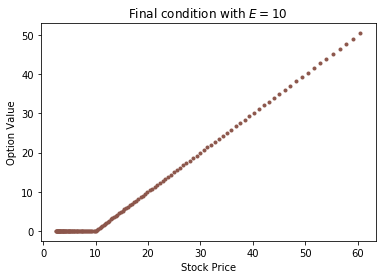

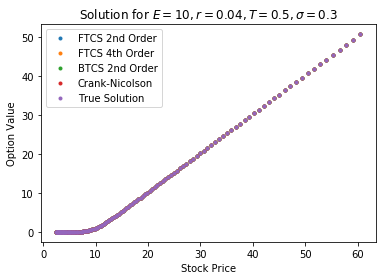

In [5]:
# Plot final condition
plt.plot(S, [max(s - E, 0) for s in S], '.', color='C5')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('Final condition with $E={}$'.format(E))
plt.show()

# Plot solution computed by each method along with true solution
for res in results:
    plt.plot(S, res['V'], '.', label=res['name'])
plt.plot(S, V_true, '.', label='True Solution')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('Solution for $E={}, r={}, T={}, \sigma={}$'.format(E, r, T, sigma))
plt.legend()
plt.show()

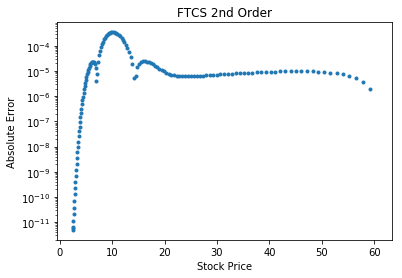

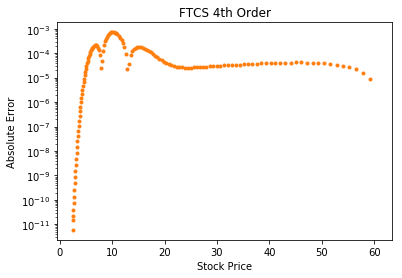

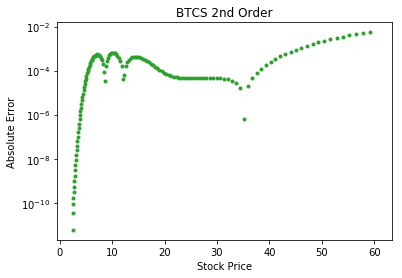

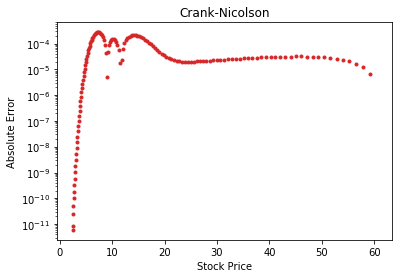

In [6]:
# Plot errors for each method
for i, res in enumerate(results):
    plt.semilogy(S, np.abs(res['V'] - V_true), '.', color='C{}'.format(i))
    plt.xlabel('Stock Price')
    plt.ylabel('Absolute Error')
    plt.title(res['name'])
    plt.show()

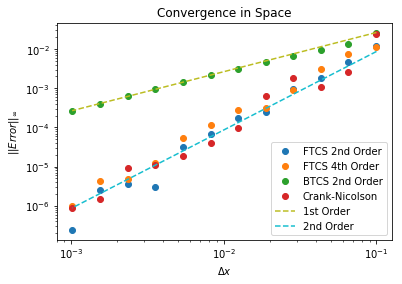

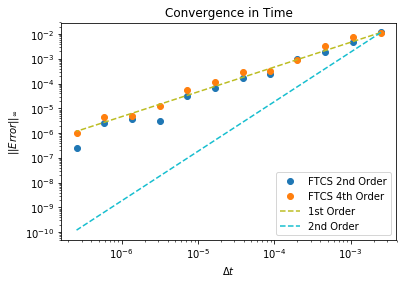

In [7]:
## Convergence analysis

# Black-Scholes parameters
E = 10
r = 0.04
T = 0.5
sigma = 0.3

# Discretization
L = 3.2
m_vals = np.logspace(1.5, 3.5, 12, dtype=int)
n_vals = np.array(2 * sigma**2 * T * ((m_vals+2)/L)**2, dtype=int)
delta_x = L / (m_vals+1)
delta_t = 0.5 * sigma**2 * T / n_vals

# Initialize lists to hold errors
err_F2 = []
err_F4 = []
err_B2 = []
err_CN = []

# Compute errors for explicit methods (delta_t = 1/4 * delta_x^2)
for m, n in zip(m_vals, n_vals):
    S_F2, V_F2 = bls_solve('ftcs2', m, n, E, r, T, sigma)
    S_F4, V_F4 = bls_solve('ftcs4', m, n, E, r, T, sigma)
    err_F2.append(np.linalg.norm(V_F2 - bls_euro_call(S_F2, E, r, T, sigma), ord=np.inf))
    err_F4.append(np.linalg.norm(V_F4 - bls_euro_call(S_F4, E, r, T, sigma), ord=np.inf))

# Compute errors for implicit methods (delta_t = C * delta_x)
for m in m_vals:
    n = int(10/7*m)
    S_B2, V_B2 = bls_solve('btcs2', m, n, E, r, T, sigma)
    S_CN, V_CN = bls_solve('cn', m, n, E, r, T, sigma)
    err_B2.append(np.linalg.norm(V_B2 - bls_euro_call(S_B2, E, r, T, sigma), ord=np.inf))
    err_CN.append(np.linalg.norm(V_CN - bls_euro_call(S_CN, E, r, T, sigma), ord=np.inf))

# Plot convergence in space
plt.loglog(delta_x, err_F2, 'o', label='FTCS 2nd Order')
plt.loglog(delta_x, err_F4, 'o', label='FTCS 4th Order')
plt.loglog(delta_x, err_B2, 'o', label='BTCS 2nd Order')
plt.loglog(delta_x, err_CN, 'o', label='Crank-Nicolson')
plt.loglog(delta_x, err_B2[-1]/delta_x[-1] * delta_x, '--', color='C8', label='1st Order')
plt.loglog(delta_x, err_CN[-1]/delta_x[-1]**2 * delta_x**2, '--', color='C9', label='2nd Order')
plt.xlabel('$\Delta x$')
plt.ylabel('$||Error||_\infty$')
plt.title('Convergence in Space')
plt.legend(loc=4)
plt.show()

# Plot convergence in time
plt.loglog(delta_t, err_F2, 'o', label='FTCS 2nd Order')
plt.loglog(delta_t, err_F4, 'o', label='FTCS 4th Order')
plt.loglog(delta_t, err_F2[0]/delta_t[0] * delta_t, '--', color='C8', label='1st Order')
plt.loglog(delta_t, err_F2[0]/delta_t[0]**2 * delta_t**2, '--', color='C9', label='2nd Order')
plt.xlabel('$\Delta t$')
plt.ylabel('$||Error||_\infty$')
plt.title('Convergence in Time')
plt.legend(loc=4)
plt.show()

In [8]:
def bls_inverse(V, E, r, T, tolerance=1e-4, max_steps=100, method='cn', m=140, n=200):
    """Solve the inverse problem of option pricing assuming constant volatility

    :Input:
     - *V* (ndarray) Observed option values
     - *E* (float) Strike price
     - *r* (float) Risk-free interest rate
     - *T* (float) Time to maturity

    :Output:
     - *sigma* (float) Volatility of underlying stock
    """
    # Define function to minimize
    def f(sigma):
        _, V_hat = bls_solve(method, m, n, E, r, T, sigma)
        return np.linalg.norm(V_hat - V, ord=np.inf)

    # Golden ratio
    phi = (1.0 + np.sqrt(5.0)) / 2.0

    # Initialize golden search bracket
    x = [0, None, None, 1]
    x[1] = x[3] - 1.0 / phi * (x[3] - x[0])
    x[2] = x[0] + 1.0 / phi * (x[3] - x[0])

    # Run golden search algorithm
    for _ in range(max_steps):
        # Evaluate objective function
        f_1 = f(x[1])
        f_2 = f(x[2])

        # Update bracket
        if f_1 < f_2:
            # Pick the left bracket
            x_new = [x[0], None, x[1], x[2]]
            x_new[1] = 1.0 / phi * (x[1] - x[0]) + x[0]
        else:
            # Pick the right bracket
            x_new = [x[1], x[2], None, x[3]]
            x_new[2] = (x[2] - x[1]) / phi + x[2]

        x = x_new

        # Check for convergence
        if np.abs(x[3] - x[0]) < tolerance:
            return (x[0] + x[3]) / 2

    raise ValueError('Reached maximum number of iterations')

In [9]:
# Seed random number generator for consistent output
np.random.seed(4301)

# Discretization
m = 140
n = 200

# Black-Scholes parameters
E = 12
r = 0.03
T = 0.8
sigma = 0.4

# Compute true option values
S, _ = bls_solve('cn', m, n, E, r, T, sigma)
V = bls_euro_call(S, E, r, T, sigma)

# Generate noise
noise = 0.05 * np.random.randn(len(V))

# Solve inverse problem without and with noise
sigma_hat = bls_inverse(V, E, r, T)
sigma_hat_noise = bls_inverse(V + noise, E, r, T)

print('Estimated volatility without noise is', sigma_hat)
print('Estimated volatility with noise is', sigma_hat_noise)

Estimated volatility without noise is 0.4000066106961352
Estimated volatility with noise is 0.39428933086864476
